<a href="https://colab.research.google.com/github/trehansalil/sentence_ner/blob/copilot%2Ffix-a6d2d533-4f22-45c8-b3d9-c24a6e371bd0/notebooks/01_data_exploration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Exploration for NER Dataset

This notebook explores the Named Entity Recognition (NER) dataset to understand its structure, distribution, and characteristics.

In [ ]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os

# Add src directory to path
sys.path.append('../')  # Add parent directory to path so we can import src modules

from src.utils import (
    load_dataset, get_unique_tags, get_tag_distribution,
    plot_tag_distribution, print_dataset_info,
    get_sentence_length_stats, plot_sentence_length_distribution
)
from src.data_preprocessing import analyze_dataset

# Set style for plots
plt.style.use('default')
sns.set_palette("husl")

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 20)

## 1. Load and Basic Inspection

In [5]:
# Load the dataset
data_path = './data/ner_dataset.csv'
df = load_dataset(data_path)

print("Dataset loaded successfully!")
print(f"Dataset shape: {df.shape}")
print("\nFirst few rows:")
df.head(10)

Dataset loaded successfully!
Dataset shape: (1048575, 4)

First few rows:


,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,NaN,of,IN,O
2,NaN,demonstrators,NNS,O
3,NaN,have,VBP,O
4,NaN,marched,VBN,O
5,NaN,through,IN,O
6,NaN,London,NNP,B-geo
7,NaN,to,TO,O
8,NaN,protest,VB,O
9,NaN,the,DT,O


In [6]:
# Basic dataset information
print_dataset_info(df)

Dataset Information:
Shape: (1048575, 4)
Columns: ['Sentence #', 'Word', 'POS', 'Tag']
Number of unique sentences: 47959
Number of unique words: 35177
Number of unique tags: 17
Unique tags: ['B-art', 'B-eve', 'B-geo', 'B-gpe', 'B-nat', 'B-org', 'B-per', 'B-tim', 'I-art', 'I-eve', 'I-geo', 'I-gpe', 'I-nat', 'I-org', 'I-per', 'I-tim', 'O']


In [7]:
# Check for missing values
print("Missing values per column:")
print(df.isnull().sum())

print("\nData types:")
print(df.dtypes)

Missing values per column:
Sentence #    1000616
Word               10
POS                 0
Tag                 0
dtype: int64

Data types:
Sentence #    object
Word          object
POS           object
Tag           object
dtype: object


## 2. NER Tags Analysis

In [8]:
# Get unique tags and their distribution
unique_tags = get_unique_tags(df)
tag_distribution = get_tag_distribution(df)

print(f"Number of unique NER tags: {len(unique_tags)}")
print(f"Unique tags: {unique_tags}")

print("\nTag distribution:")
for tag, count in sorted(tag_distribution.items(), key=lambda x: x[1], reverse=True):
    percentage = (count / len(df)) * 100
    print(f"{tag}: {count:,} ({percentage:.2f}%)")

Number of unique NER tags: 17
Unique tags: ['B-art', 'B-eve', 'B-geo', 'B-gpe', 'B-nat', 'B-org', 'B-per', 'B-tim', 'I-art', 'I-eve', 'I-geo', 'I-gpe', 'I-nat', 'I-org', 'I-per', 'I-tim', 'O']

Tag distribution:
O: 887,908 (84.68%)
B-geo: 37,644 (3.59%)
B-tim: 20,333 (1.94%)
B-org: 20,143 (1.92%)
I-per: 17,251 (1.65%)
B-per: 16,990 (1.62%)
I-org: 16,784 (1.60%)
B-gpe: 15,870 (1.51%)
I-geo: 7,414 (0.71%)
I-tim: 6,528 (0.62%)
B-art: 402 (0.04%)
B-eve: 308 (0.03%)
I-art: 297 (0.03%)
I-eve: 253 (0.02%)
B-nat: 201 (0.02%)
I-gpe: 198 (0.02%)
I-nat: 51 (0.00%)


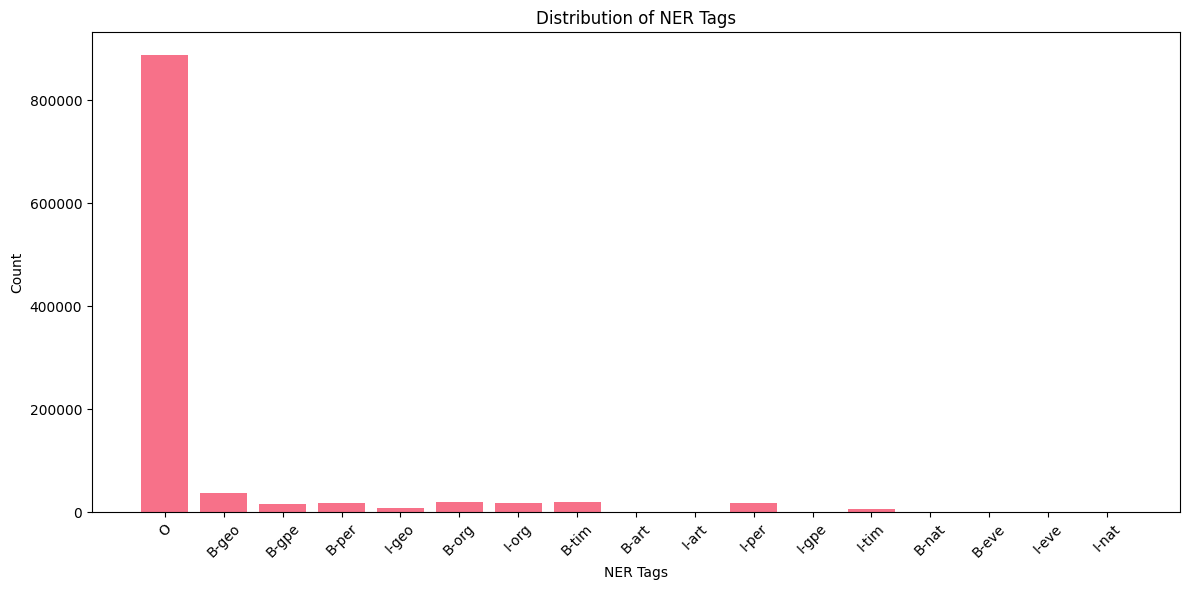

In [9]:
# Plot tag distribution
plot_tag_distribution(tag_distribution, "Distribution of NER Tags")

In [10]:
# Analyze entity types (B- and I- tags)
entity_tags = [tag for tag in unique_tags if tag.startswith(('B-', 'I-'))]
entity_types = set(tag[2:] for tag in entity_tags if len(tag) > 2)

print(f"Number of entity types: {len(entity_types)}")
print(f"Entity types: {sorted(entity_types)}")

# Count entities by type
entity_type_counts = {}
for entity_type in entity_types:
    b_count = df[df['Tag'] == f'B-{entity_type}'].shape[0]
    i_count = df[df['Tag'] == f'I-{entity_type}'].shape[0]
    entity_type_counts[entity_type] = {'B': b_count, 'I': i_count, 'Total': b_count + i_count}

entity_df = pd.DataFrame(entity_type_counts).T
entity_df = entity_df.sort_values('Total', ascending=False)
print("\nEntity type distribution:")
print(entity_df)

Number of entity types: 8
Entity types: ['art', 'eve', 'geo', 'gpe', 'nat', 'org', 'per', 'tim']

Entity type distribution:
         B      I  Total
geo  37644   7414  45058
org  20143  16784  36927
per  16990  17251  34241
tim  20333   6528  26861
gpe  15870    198  16068
art    402    297    699
eve    308    253    561
nat    201     51    252


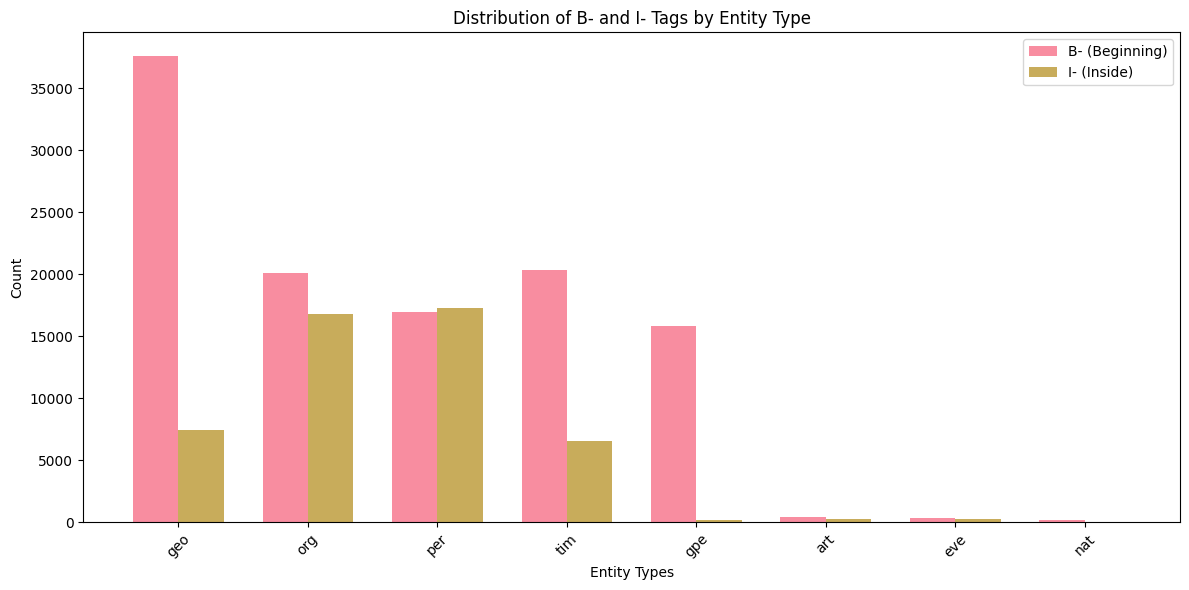

In [11]:
# Plot entity types distribution
plt.figure(figsize=(12, 6))
x = range(len(entity_df))
width = 0.35

plt.bar([i - width/2 for i in x], entity_df['B'], width, label='B- (Beginning)', alpha=0.8)
plt.bar([i + width/2 for i in x], entity_df['I'], width, label='I- (Inside)', alpha=0.8)

plt.xlabel('Entity Types')
plt.ylabel('Count')
plt.title('Distribution of B- and I- Tags by Entity Type')
plt.xticks(x, entity_df.index, rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

## 3. Sentence Analysis

In [12]:
# Sentence length statistics
sentence_stats = get_sentence_length_stats(df)

print("Sentence length statistics:")
for stat, value in sentence_stats.items():
    print(f"{stat.replace('_', ' ').title()}: {value:.2f}")

Sentence length statistics:
Mean Length: 1.00
Median Length: 1.00
Min Length: 1.00
Max Length: 1.00
Std Length: 0.00


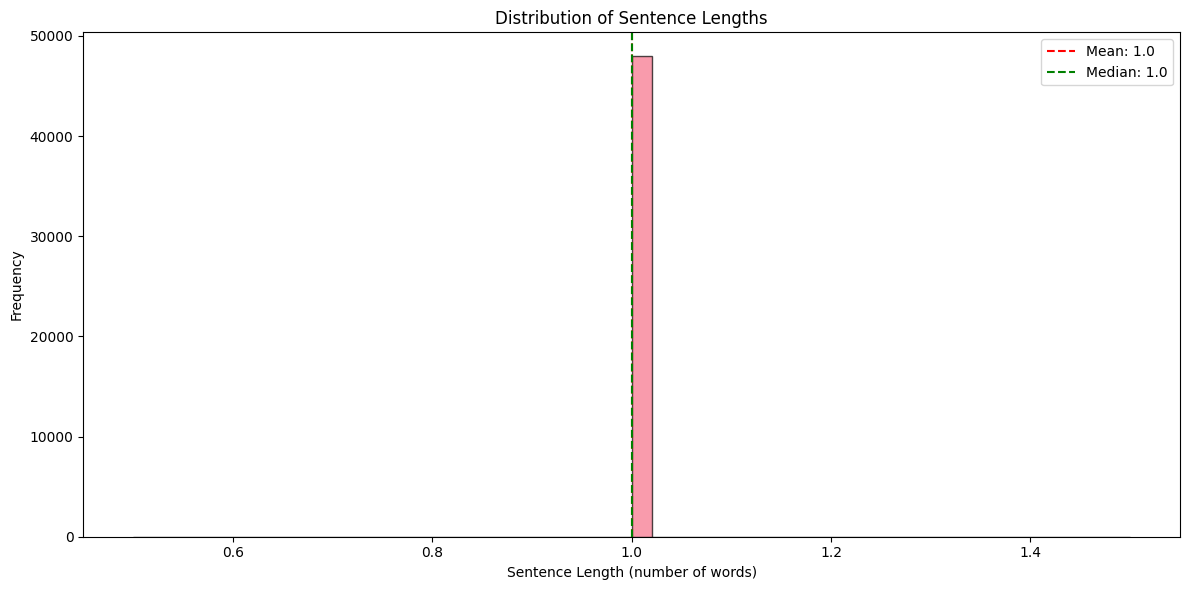

In [13]:
# Plot sentence length distribution
plot_sentence_length_distribution(df)

In [15]:
# Analyze some sample sentences
print("Sample sentences with their tags:")
for sent_id in df['Sentence #'].unique()[:5]:
    sent_data = df[df['Sentence #'] == sent_id]
    words = sent_data['Word'].tolist()
    tags = sent_data['Tag'].tolist()

    print(f"\n{sent_id}:")
    print(f"Words: {' '.join(words)}")
    print(f"Tags:  {' '.join(tags)}")

    # Extract entities from this sentence
    from src.utils import extract_entities
    entities = extract_entities(words, tags)
    if entities:
        print(f"Entities: {entities}")

Sample sentences with their tags:

Sentence: 1:
Words: Thousands
Tags:  O

nan:
Words: 
Tags:  

Sentence: 2:
Words: Families
Tags:  O

Sentence: 3:
Words: They
Tags:  O

Sentence: 4:
Words: Police
Tags:  O


## 4. Vocabulary Analysis

In [16]:
# Word frequency analysis
word_counts = df['Word'].value_counts()

print(f"Total vocabulary size: {len(word_counts)}")
print(f"Most frequent words:")
print(word_counts.head(20))

print(f"\nLeast frequent words (sample):")
print(word_counts.tail(10))

Total vocabulary size: 35177
Most frequent words:
Word
the     52573
.       47761
,       32754
of      26354
in      26323
to      23213
a       20481
and     19936
The     11313
's      10923
for      8498
has      7216
is       6746
on       6710
that     6301
have     5485
with     5381
said     5321
was      4878
says     4640
Name: count, dtype: int64

Least frequent words (sample):
Word
C.              1
Cubana          1
complemented    1
braved          1
Gisagara        1
Mikulski        1
dispel          1
Bus             1
Woo-ik          1
missteps        1
Name: count, dtype: int64


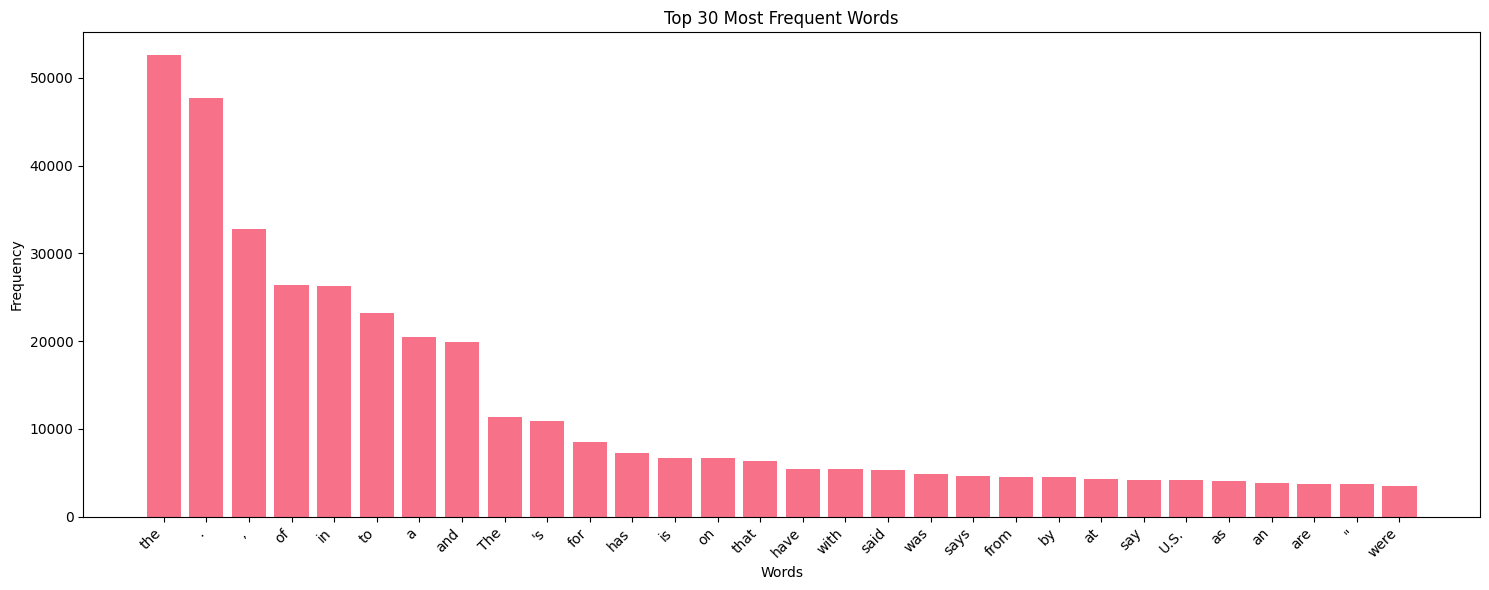

In [17]:
# Plot word frequency distribution (top 30)
plt.figure(figsize=(15, 6))
top_words = word_counts.head(30)
plt.bar(range(len(top_words)), top_words.values)
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Top 30 Most Frequent Words')
plt.xticks(range(len(top_words)), top_words.index, rotation=45, ha='right')
plt.tight_layout()
plt.show()

Word frequency distribution:
Words appearing once: 14797
Words appearing 2-5 times: 6535
Words appearing 6-10 times: 2514
Words appearing >10 times: 6324


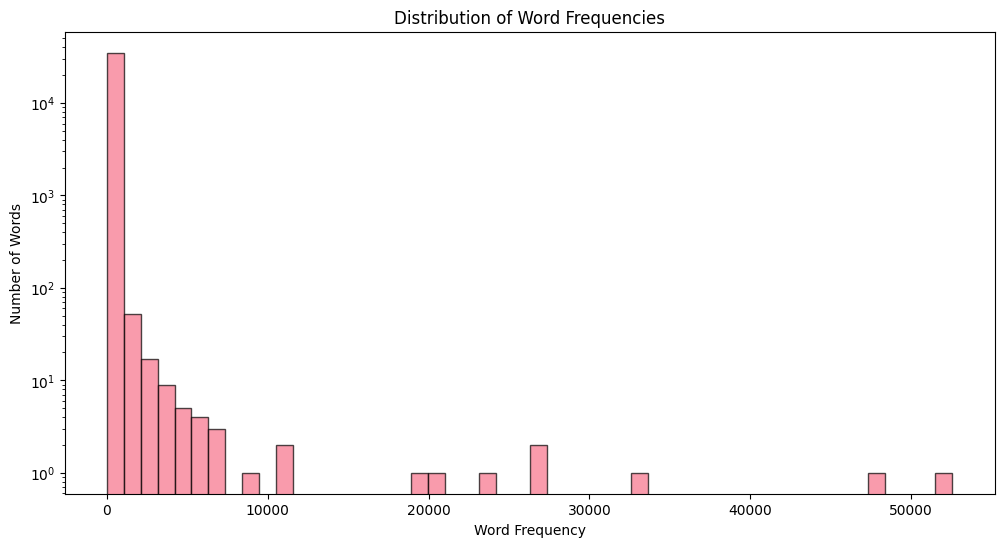

In [18]:
# Analyze word frequency distribution
freq_counts = word_counts.value_counts().sort_index()

print("Word frequency distribution:")
print(f"Words appearing once: {freq_counts[1] if 1 in freq_counts else 0}")
print(f"Words appearing 2-5 times: {freq_counts[2:6].sum() if len(freq_counts) > 2 else 0}")
print(f"Words appearing 6-10 times: {freq_counts[6:11].sum() if len(freq_counts) > 6 else 0}")
print(f"Words appearing >10 times: {freq_counts[11:].sum() if len(freq_counts) > 11 else 0}")

# Plot frequency of frequencies
plt.figure(figsize=(12, 6))
plt.hist(word_counts.values, bins=50, edgecolor='black', alpha=0.7)
plt.xlabel('Word Frequency')
plt.ylabel('Number of Words')
plt.title('Distribution of Word Frequencies')
plt.yscale('log')
plt.show()

## 5. Comprehensive Dataset Analysis

In [19]:
# Use the comprehensive analysis function
analysis_results = analyze_dataset(df)

print("Comprehensive Dataset Analysis:")
print("=" * 50)

for key, value in analysis_results.items():
    print(f"\n{key.replace('_', ' ').title()}:")
    if isinstance(value, dict):
        for sub_key, sub_value in value.items():
            print(f"  {sub_key}: {sub_value}")
    else:
        print(f"  {value}")

Comprehensive Dataset Analysis:

Total Tokens:
  1048575

Unique Sentences:
  47959

Unique Words:
  35177

Unique Tags:
  17

Tag Distribution:
  O: 887908
  B-geo: 37644
  B-tim: 20333
  B-org: 20143
  I-per: 17251
  B-per: 16990
  I-org: 16784
  B-gpe: 15870
  I-geo: 7414
  I-tim: 6528
  B-art: 402
  B-eve: 308
  I-art: 297
  I-eve: 253
  B-nat: 201
  I-gpe: 198
  I-nat: 51

Sentence Length Stats:
  mean: 1.0
  median: 1.0
  min: 1
  max: 1
  std: 0.0

Entity Type Distribution:
  geo: 45058
  gpe: 16068
  per: 34241
  org: 36927
  tim: 26861
  art: 699
  nat: 252
  eve: 561


## 6. Data Quality Assessment

In [20]:
# Check for potential data quality issues
print("Data Quality Assessment:")
print("=" * 30)

# Check for consecutive B- tags of the same type (potential issue)
consecutive_b_issues = 0
for sent_id in df['Sentence #'].unique()[:1000]:  # Check first 1000 sentences
    sent_data = df[df['Sentence #'] == sent_id]
    tags = sent_data['Tag'].tolist()

    for i in range(len(tags) - 1):
        if tags[i].startswith('B-') and tags[i+1].startswith('B-') and tags[i] == tags[i+1]:
            consecutive_b_issues += 1
            if consecutive_b_issues <= 5:  # Show first 5 examples
                print(f"Consecutive B- tags in {sent_id}: {tags[i]} -> {tags[i+1]}")

print(f"\nFound {consecutive_b_issues} potential consecutive B- tag issues in first 1000 sentences")

# Check for I- tags without preceding B- tags
orphan_i_issues = 0
for sent_id in df['Sentence #'].unique()[:1000]:  # Check first 1000 sentences
    sent_data = df[df['Sentence #'] == sent_id]
    tags = sent_data['Tag'].tolist()

    for i, tag in enumerate(tags):
        if tag.startswith('I-'):
            entity_type = tag[2:]
            # Check if there's a B- tag before this I- tag
            has_b_tag = False
            for j in range(i-1, -1, -1):
                if tags[j] == f'B-{entity_type}':
                    has_b_tag = True
                    break
                elif tags[j] != f'I-{entity_type}':
                    break

            if not has_b_tag:
                orphan_i_issues += 1
                if orphan_i_issues <= 5:  # Show first 5 examples
                    print(f"Orphan I- tag in {sent_id}: {tag} at position {i}")

print(f"Found {orphan_i_issues} potential orphan I- tag issues in first 1000 sentences")

Data Quality Assessment:

Found 0 potential consecutive B- tag issues in first 1000 sentences
Found 0 potential orphan I- tag issues in first 1000 sentences


## 7. Summary and Insights

In [21]:
print("Dataset Summary and Key Insights:")
print("=" * 40)

print(f"📊 Dataset Size: {df.shape[0]:,} tokens across {df['Sentence #'].nunique():,} sentences")
print(f"📝 Vocabulary: {df['Word'].nunique():,} unique words")
print(f"🏷️  NER Tags: {df['Tag'].nunique()} unique tags")
print(f"🎯 Entity Types: {len(entity_types)} types ({', '.join(sorted(entity_types))})")

print(f"\n📏 Sentence Lengths:")
print(f"   • Average: {sentence_stats['mean_length']:.1f} words")
print(f"   • Range: {sentence_stats['min_length']} - {sentence_stats['max_length']} words")
print(f"   • Median: {sentence_stats['median_length']:.1f} words")

o_percentage = (tag_distribution['O'] / len(df)) * 100
entity_percentage = 100 - o_percentage
print(f"\n🔍 Tag Distribution:")
print(f"   • Non-entity tokens (O): {o_percentage:.1f}%")
print(f"   • Entity tokens: {entity_percentage:.1f}%")

print(f"\n💡 Key Insights:")
print(f"   • This is a {['small', 'medium', 'large'][2 if df.shape[0] > 100000 else 1 if df.shape[0] > 10000 else 0]} dataset")
print(f"   • Entity density: {'High' if entity_percentage > 30 else 'Medium' if entity_percentage > 15 else 'Low'}")
print(f"   • Vocabulary richness: {'High' if df['Word'].nunique() > 20000 else 'Medium' if df['Word'].nunique() > 5000 else 'Low'}")
print(f"   • Sentence complexity: {'High' if sentence_stats['mean_length'] > 25 else 'Medium' if sentence_stats['mean_length'] > 15 else 'Low'}")

Dataset Summary and Key Insights:
📊 Dataset Size: 1,048,575 tokens across 47,959 sentences
📝 Vocabulary: 35,177 unique words
🏷️  NER Tags: 17 unique tags
🎯 Entity Types: 8 types (art, eve, geo, gpe, nat, org, per, tim)

📏 Sentence Lengths:
   • Average: 1.0 words
   • Range: 1 - 1 words
   • Median: 1.0 words

🔍 Tag Distribution:
   • Non-entity tokens (O): 84.7%
   • Entity tokens: 15.3%

💡 Key Insights:
   • This is a large dataset
   • Entity density: Medium
   • Vocabulary richness: High
   • Sentence complexity: Low


## Conclusion

This exploration provides a comprehensive understanding of the NER dataset:

1. **Dataset Scale**: Large-scale dataset suitable for training robust NER models
2. **Entity Diversity**: Multiple entity types with varying frequencies
3. **Text Complexity**: Diverse sentence lengths and vocabulary
4. **Data Quality**: Generally well-formatted IOB2 tagging with minimal issues

The insights from this exploration will guide the preprocessing steps and model architecture decisions in subsequent notebooks.